# Introduction to Algorithmic Trading in Python

This notebook and the accompanying python file for algorithm deployment are meant to be the very most basic introduction into algorithmic trading in python. This code was written in 1 day and is in no way meant to reflect what actual algorithmic trading looks like. It is meant to serve as an introduction to a few topics in the algorithmic trading space.

**Things that will be covered:**
- Getting access to historical pricing data
- Basic benchmarking and evaluation
- Target labeling strategies
- Basic technical indicators for feature creation
- Model building for trading
- Basic Backtesting
- Deployment to paper trading

**Things that will NOT be covered:**
- Data transformations and normalization
- Fundamental Analysis
- Portfolio optimization
- Signal searching
- Error analysis
- Bet sizing
- So many other things  

## Data Access
We are going to be using [Alpaca](https://alpaca.markets/docs/introduction/) to be accessing data and also for our paper trading. Would recommend if you want to quickly get something going. Super easy to use, as you will see below.

In [28]:
import pandas as pd
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.enums import Adjustment
from datetime import datetime, date, timedelta
from alpaca.data.timeframe import TimeFrame
import os
from dotenv import find_dotenv, load_dotenv
import seaborn as sns

sns.set(rc={"figure.figsize": (15, 8)})
import quantstats as qs

qs.extend_pandas()
from finta import TA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

### API Keys
I have stored the API keys for Alpaca in a .env file. Here we load them in so we have access to them through `os.getenv`

In [2]:
load_dotenv(find_dotenv())

client = StockHistoricalDataClient(
    os.getenv("ALPACA_API_KEY"), os.getenv("ALPACA_SECRET_KEY")
)

### Pulling Data
For this example, we are only going to trade 1 stock, `AAPL`. We are going to grab all the daily price data from the beginning of 2016 to the end of 2021 taking into account both dividend adjustments and stock splits.

In [3]:
response = client.get_stock_bars(
    StockBarsRequest(
        symbol_or_symbols=["AAPL"],
        start=datetime(2016, 1, 1),
        end=datetime(2022, 1, 1),
        timeframe=TimeFrame.Day,
        adjustment=Adjustment.ALL,
    )
)

df = response.df
df.index = [i[1] for i in df.index]

df["daily_percent_change"] = df["close"].pct_change()
df = df.dropna()
df.index = pd.DatetimeIndex(pd.to_datetime(df.index).date)

df.tail()

,open,high,low,close,volume,trade_count,vwap,daily_percent_change
2021-12-27,176.37,179.68,176.34,179.59,74928619.0,629427.0,178.32,0.023013
2021-12-28,179.46,180.58,177.79,178.55,79103834.0,631315.0,178.97,-0.005791
2021-12-29,178.56,179.89,177.41,178.64,62325923.0,491575.0,178.72,0.000504
2021-12-30,178.85,179.83,177.36,177.47,59770363.0,498610.0,178.64,-0.006549
2021-12-31,177.27,178.49,176.53,176.84,64038545.0,451475.0,177.07,-0.003550


## Labeling Values with the Triple Barrier Method
The general idea of the triple barrier method is that there are 3 barriers that a price can hit across time. A top barrier, a bottom barrier, and a right barrier. Whichever barrier is hit first is how we label things. To do this we need to set a percent change for the top and bottom, and a time frame for the right window. Below are 2 examples of what this method looks like.

Text(0.5, 1.0, 'Triple Barrier Method')

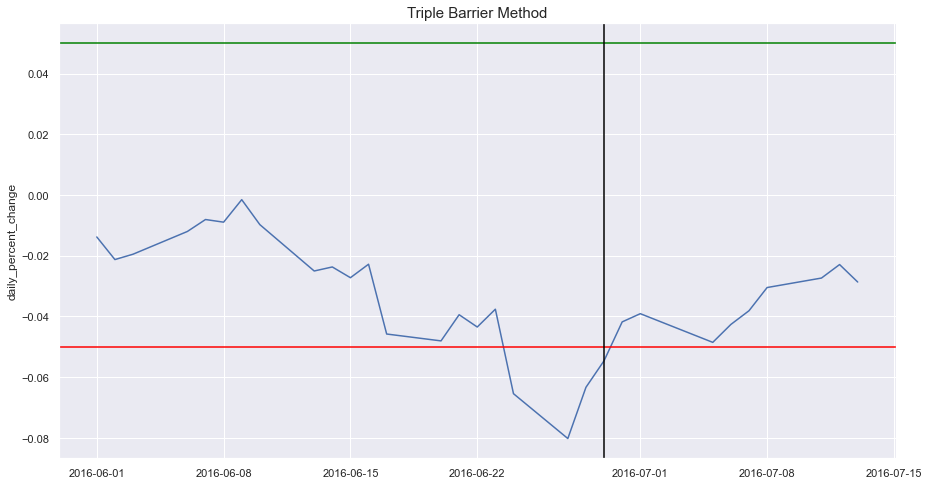

In [29]:
sample = df[100:130]
grid = sns.lineplot(x=sample.index, y=sample.daily_percent_change.cumsum())
grid.axhline(0.05, color="green")
grid.axhline(-0.05, color="red")
grid.axvline(x=df.index[120], color="black")
grid.set_title("Triple Barrier Method", fontsize=15)

Text(0.5, 1.0, 'Triple Barrier Method')

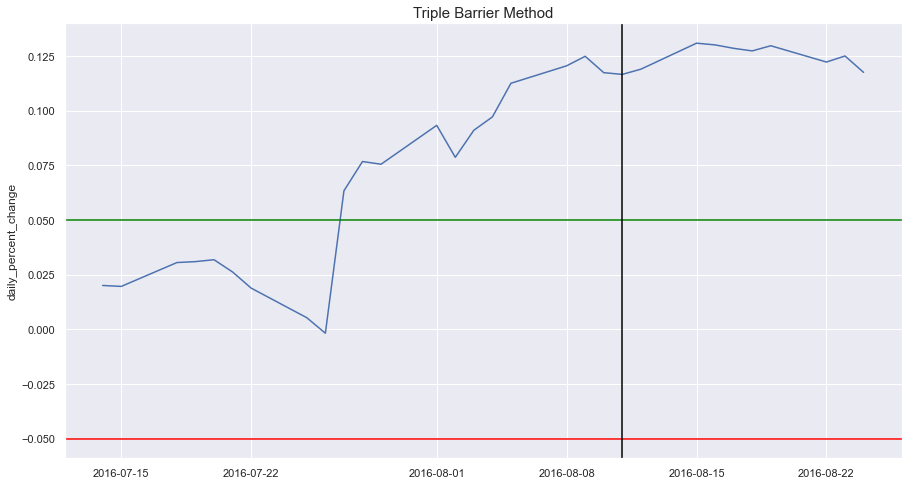

In [30]:
sample = df[130:160]
grid = sns.lineplot(x=sample.index, y=sample.daily_percent_change.cumsum())
grid.axhline(0.05, color="green")
grid.axhline(-0.05, color="red")
grid.axvline(x=df.index[150], color="black")
grid.set_title("Triple Barrier Method", fontsize=15)

In [6]:
def triple_barrier_labels(
    data: pd.Series, n_days: int = 3, upper: float = 0.01, lower: float = 0.01
) -> pd.Series:
    labels = []
    index = []
    lower = -lower
    for i in range(len(data) - n_days + 1):
        group = data[i : i + n_days]
        cumsum = group.cumsum()
        index.append(group.index[-1])
        if max(cumsum) >= upper and min(cumsum) > lower:
            labels.append(1)
        elif max(cumsum) < upper and min(cumsum) <= lower:
            labels.append(-1)
        elif max(cumsum) >= upper and min(cumsum) <= lower:
            if min(cumsum[cumsum >= upper].index) > min(cumsum[cumsum <= lower].index):
                labels.append(-1)
            else:
                labels.append(1)
        else:
            labels.append(0)
    return pd.Series(labels, index=index, name="Target")

In [7]:
labels = triple_barrier_labels(df["daily_percent_change"])
x = df.copy()
df = pd.merge(df, labels, right_index=True, left_index=True)

 1    733
-1    497
 0    278
Name: Target, dtype: int64


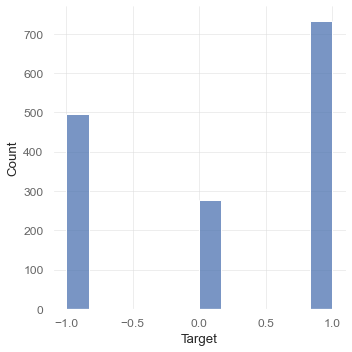

In [8]:
print(df.Target.value_counts())

sns.displot(labels)

## Feature Creation and Technical Indicators

In [9]:
ohlc = x[["open", "high", "low", "close", "volume"]]

In [10]:
x["ssma"] = TA.SSMA(ohlc, period=30)
x["msd"] = TA.MSD(ohlc, period=30)
x["adx"] = TA.ADX(ohlc, period=30)
x["rsi"] = TA.RSI(ohlc, period=30)
x[["bband_upper", "bband_middle", "bband_lower"]] = TA.BBANDS(ohlc, period=30)
x["cross_lower_band"] = x["ssma"] < x["bband_lower"]
x["cross_back_lower_band"] = (
    ~x["cross_lower_band"].shift(1).fillna(False) & x["cross_lower_band"]
)

#### Smoothed Simple Moving Average & Moving Standard Deviation

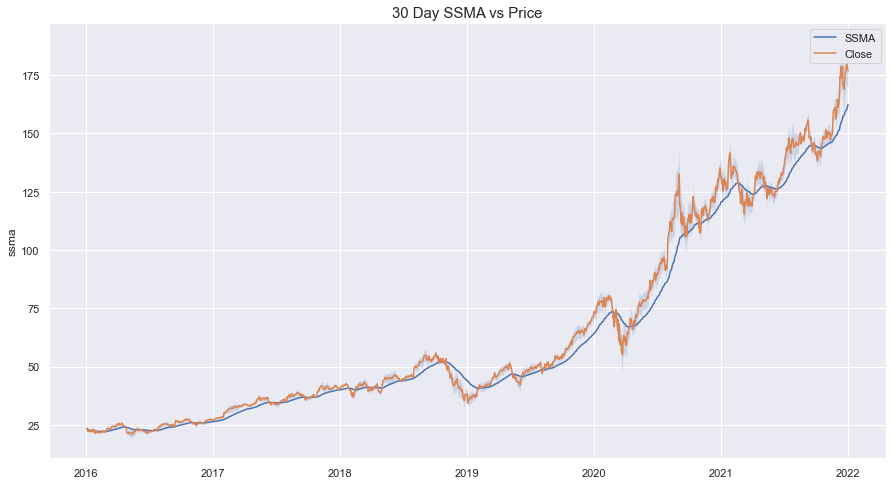

In [31]:
grid = sns.lineplot(x=x.index, y=x.ssma)
grid = sns.lineplot(x=x.index, y=x.close)
grid.set_title("30 Day SSMA vs Price", fontsize=15)
grid.fill_between(x.index, x.close - x.msd, x.close + x.msd, alpha=0.2)
grid.legend(["SSMA", "Close"])

#### Average Direction Index
This is basically a strength of trend indicator. Read more here https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp

Text(0.5, 1.0, '30 Day ADX')

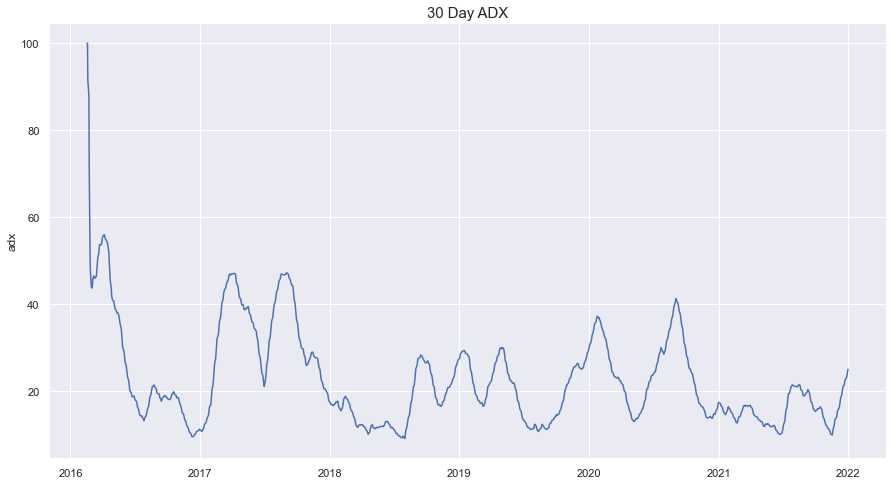

In [32]:
grid = sns.lineplot(x=x.index, y=x.adx)
grid.set_title("30 Day ADX", fontsize=15)

#### Bollinger Bands
Bollinger bands provide an upper and lower band. When prices cross these bands, they can provide a good trading signal combined with some other indicators such as RSI. Read more here https://www.investopedia.com/terms/b/bollingerbands.asp

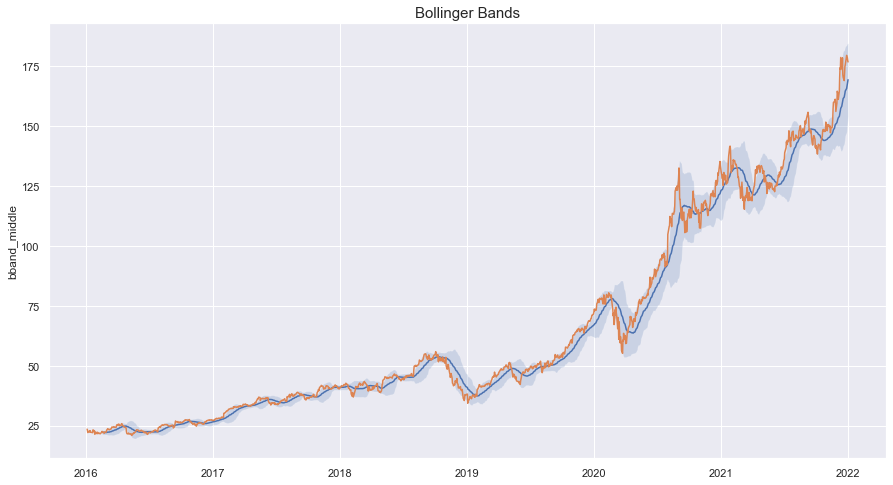

In [33]:
grid = sns.lineplot(x=x.index, y=x.bband_middle)
grid = sns.lineplot(x=x.index, y=x.close)

grid.set_title("Bollinger Bands", fontsize=15)
grid.fill_between(x.index, x.bband_upper, x.bband_lower, alpha=0.2)

### Relative Strength Index
Measures the speed of recent price changes.

Text(0.5, 1.0, 'RSI')

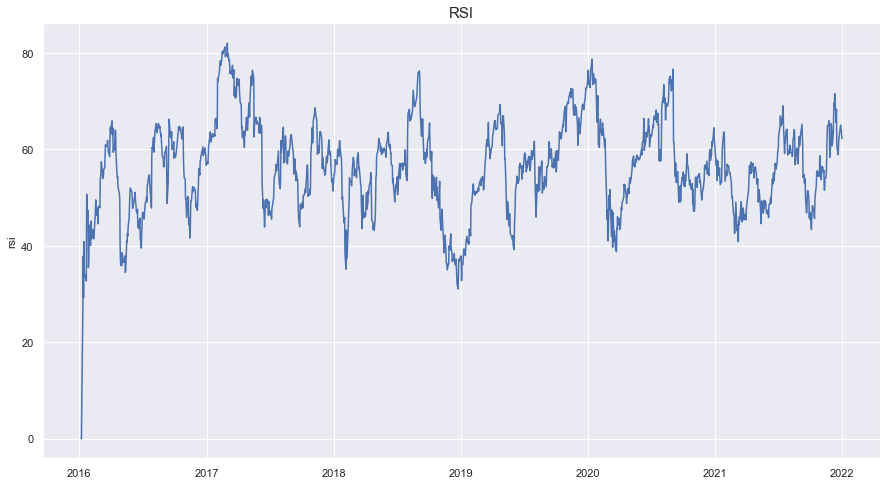

In [34]:
grid = sns.lineplot(x=x.index, y=x.rsi)
grid.set_title("RSI", fontsize=15)

Text(0.5, 1.0, 'Feature Heatmap')

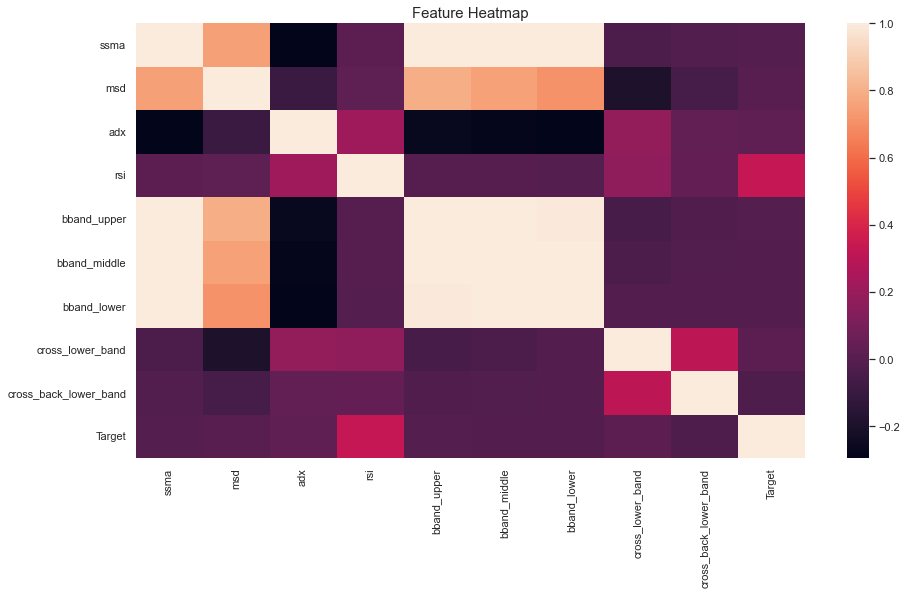

In [35]:
features = [
    "ssma",
    "msd",
    "adx",
    "rsi",
    "bband_upper",
    "bband_middle",
    "bband_lower",
    "cross_lower_band",
    "cross_back_lower_band",
]
data = pd.merge(x, labels, left_index=True, right_index=True)
corrs = data[features + ["Target"]].corr()
grid = sns.heatmap(corrs)
grid.set_title("Feature Heatmap", fontsize=15)

## Backtesting
Backtesting is the act of testing a trading strategy on historic data. In this setting, we are going to ignore a lot of factors that would make backtesting realistic such as fees, market rules, margin, etc. We set a default amount of cash to start with and on each day of a backtest, update our holdings and cash accordingly before calculating our total portfolio value.

In [16]:
perfect_strategy = labels

In [17]:
def backtest(prices: pd.Series, signals: pd.Series) -> pd.Series:
    assert len(prices) == len(signals)
    cash = 100
    holdings = 0
    position = 0
    returns = []
    index = prices.index
    for s, p in zip(signals, prices):
        if s == 1 and position == 0:
            cash -= p
            position = 1

        if s == -1 and position == 1:
            cash += p
            position = 0

        holdings = position * p
        returns.append(cash + holdings)

    return pd.Series(returns, index=index)

In [18]:
perfect_results = backtest(data.close, perfect_strategy)
benchmark_results = backtest(data.close, [1] + [0] * (len(data) - 1))

## Benchmarks and Evaluation
It is important to have a benchmark to compare a strategy to so that we can know if a strategy is outperforming the market. In this case, we are using a buy and hold strategy on AAPL to set our benchmark. In many cases things like SPY or other indexes act as great benchmarks.

Once we have a benchmark we need a way to evaluate it against our strategy. We are going to focus on 2 evaluation metrics.
1. Cumulative Return: The percent return of a strategy over the course of a backtest.
2. Sharpe Ratio: A very imperfect metric, but one that takes into account the risk taken and the returns recieved. So higher is better

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-01-07  2016-01-07
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      63.0%       100.0%

Cumulative Return   75.15%      154.73%
CAGR﹪              9.81%       16.91%

Sharpe              0.87        1.22
Prob. Sharpe Ratio  98.29%      99.85%
Sortino             1.29        1.8
Sortino/√2          0.91        1.28
Omega               1.25        1.25

Max Drawdown        -13.1%      -16.09%
Longest DD Days     435         371

Gain/Pain Ratio     0.25        0.27
Gain/Pain (1M)      1.19        1.61

Payoff Ratio        1.08        1.08
Profit Factor       1.25        1.27
Common Sense Ratio  1.53        1.39
CPC Index           0.72        0.75
Tail Ratio          1.22        1.09
Outlier Win Ratio   8.74        4.37
Outlier Loss Ratio  4.33        4.46

MTD                 0.77%       5.04%
3M                  4.89%       15.

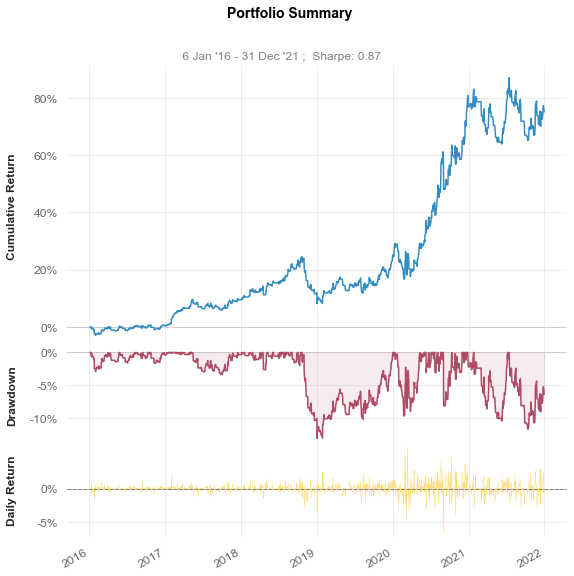

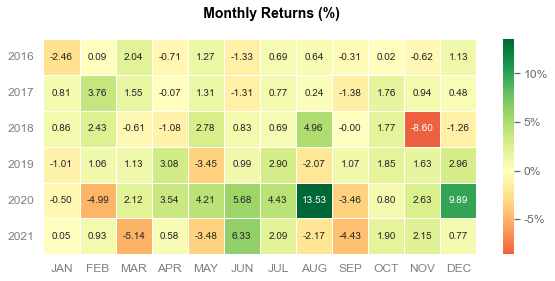

In [19]:
qs.reports.basic(perfect_results, benchmark_results)

## Modeling
We are going to build a very basic Random Forest model to fit to our labels and then make predictions. It is important when building models to not allow them to peak into the future, especially when doing hyperparameter searches.

In [20]:
splits = TimeSeriesSplit()
params = dict(
    criterion=["gini", "entropy", "log_loss"],
    max_depth=[3, 10, 50, None],
    min_samples_split=[2, 3, 4, 5],
    max_features=["sqrt", "log2", None],
    n_estimators=[25, 50, 100, 250, 500, 1000],
)
search = RandomizedSearchCV(
    RandomForestClassifier(),
    params,
    cv=splits,
    scoring="f1_macro",
    n_iter=50,
    n_jobs=-1,
)
data = data.dropna()
train = data[data.index < datetime(2018, 1, 1)]
test = data[data.index >= datetime(2018, 1, 1)]
model = search.fit(train[features], train.Target)

In [21]:
model.best_params_

{'n_estimators': 250,
 'min_samples_split': 2,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini'}

In [22]:
train_results = backtest(
    train.close, pd.Series(model.best_estimator_.predict(train[features]))
)
benchmark_results = backtest(train.close, [1] + [0] * (len(train) - 1))

### Training Results
Our model on the training set didn't quite perform as well as the benchmark either in total returns or sharpe ratio. But oh well. Let this be a lesson that beating the market is not trivial :). On we go.

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-02-18  2016-02-18
End Period          2017-12-29  2017-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      69.0%       99.0%

Cumulative Return   14.61%      17.69%
CAGR﹪              7.59%       9.14%

Sharpe              1.83        1.68
Prob. Sharpe Ratio  99.35%      98.97%
Sortino             2.82        2.62
Sortino/√2          1.99        1.85
Omega               1.49        1.49

Max Drawdown        -1.9%       -4.73%
Longest DD Days     72          152

Gain/Pain Ratio     0.49        0.36
Gain/Pain (1M)      3.13        1.71

Payoff Ratio        1.14        1.17
Profit Factor       1.49        1.36
Common Sense Ratio  1.86        1.4
CPC Index           0.96        0.87
Tail Ratio          1.25        1.03
Outlier Win Ratio   6.63        3.49
Outlier Loss Ratio  3.89        3.55

MTD                 -0.43%      -0.52%
3M                  0.22%       3.45%


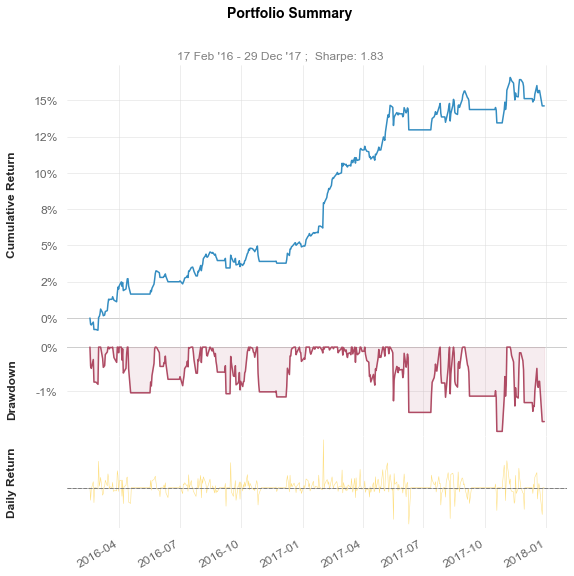

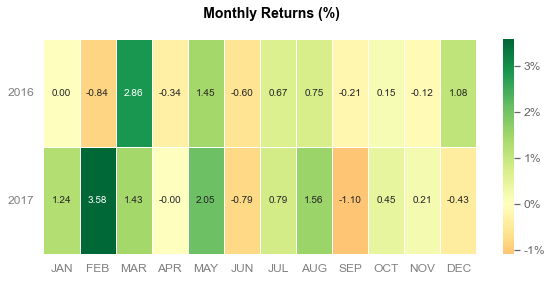

In [23]:
qs.reports.basic(train_results, benchmark_results, match_dates=True)

In [24]:
test_results = backtest(
    test.close, pd.Series(model.best_estimator_.predict(test[features]))
)
benchmark_results = backtest(test.close, [1] + [0] * (len(test) - 1))

### Test Results
We will take and it say this is worth deploying just for the sake of it.

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-01-02  2018-01-02
End Period          2021-12-31  2021-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      39.0%       100.0%

Cumulative Return   68.23%      135.82%
CAGR﹪              13.9%       23.94%

Sharpe              1.1         1.27
Prob. Sharpe Ratio  98.6%       99.4%
Sortino             1.68        1.87
Sortino/√2          1.19        1.32
Omega               1.39        1.39

Max Drawdown        -15.27%     -18.74%
Longest DD Days     464         371

Gain/Pain Ratio     0.39        0.26
Gain/Pain (1M)      1.9         1.55

Payoff Ratio        1.14        1.13
Profit Factor       1.39        1.26
Common Sense Ratio  2.17        1.3
CPC Index           0.88        0.78
Tail Ratio          1.56        1.03
Outlier Win Ratio   11.43       3.31
Outlier Loss Ratio  3.55        3.66

MTD                 7.83%       5.47%
3M                  8.69%       17.3

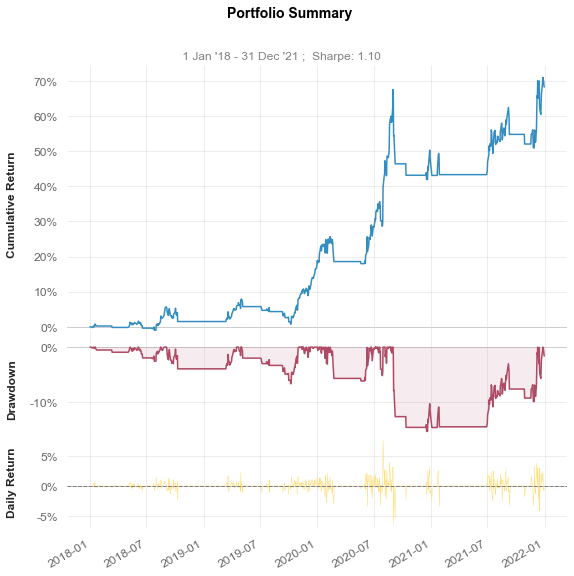

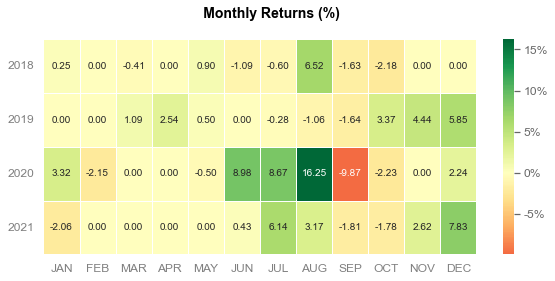

In [25]:
qs.reports.basic(test_results, benchmark_results)

In [26]:
search = RandomizedSearchCV(
    RandomForestClassifier(), params, cv=splits, scoring="f1_macro", n_iter=50
)
model = search.fit(data[features], data.Target)
model.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=3, max_features=None,
                       min_samples_split=5)

In [27]:
import joblib

joblib.dump(model.best_estimator_, "./models/rf_aapl_model.pkl")

['./models/rf_aapl_model.pkl']

## Some Final Thoughts

In general, trading is really hard. It takes a lot more than some good python and basic investing knowledge. It is a very complicated process involving a lot of risk management and math. I would strongly recommend not throwing a bunch of indicators at a model as we did here and finding one that looks amazing. That is a really good way to get false positive signals and lose money. 

If you are interested in taking a deeper dive into algorithmic trading, I would strongly recommend this book https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089